In [50]:
import sys
sys.path.insert(1, '../../libs')
from utils import get_data, temporal_train_test_split
from autorship import AuthorClassifier
from sklearn.preprocessing import MaxAbsScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.tokenize import TweetTokenizer
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from joblib import Parallel, delayed

In [3]:
data = get_data("../../data/authors.csv")

In [4]:
tt = TweetTokenizer()

estimators = [
        ('svm', LinearSVC(random_state=42, max_iter=10000)),
        ('lr_l1', LogisticRegression(random_state=42, penalty="l1", solver="liblinear"),
        ('rf'), RandomForestClassifier(random_state=42))]
stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=42, penalty="l2", solver="liblinear"))

grid = [(MultinomialNB(), CountVectorizer(ngram_range=(1,3), analyzer="word", tokenizer=tt.tokenize)),
        (LogisticRegression(random_state=42, penalty="l1", solver="liblinear"), TfidfVectorizer(ngram_range=(1,5), analyzer="char")),
        (LogisticRegression(random_state=42, penalty="l2", solver="liblinear"), TfidfVectorizer(ngram_range=(1,1), analyzer="word", tokenizer=tt.tokenize)),
        (LinearSVC(random_state=42, max_iter=10000), TfidfVectorizer(ngram_range=(1,1), analyzer="word", tokenizer=tt.tokenize)),
        (SVC(random_state=42), TfidfVectorizer(ngram_range=(1,1), analyzer="word", tokenizer=tt.tokenize)),
        (DecisionTreeClassifier(random_state=42), CountVectorizer(ngram_range=(1,3), analyzer="word", tokenizer=tt.tokenize)),
        (RandomForestClassifier(random_state=42), CountVectorizer(ngram_range=(1,1), analyzer="word", tokenizer=tt.tokenize)),
        (AdaBoostClassifier(random_state=42), CountVectorizer(ngram_range=(1,5), analyzer="char")),
        (GradientBoostingClassifier(random_state=42), CountVectorizer(ngram_range=(1,3), analyzer="char")),
        (stacking, TfidfVectorizer(ngram_range=(1,1), analyzer="word", tokenizer=tt.tokenize))
        ]

In [7]:
from joblib import Parallel, delayed
def process(clf, vectorizer):
    clf_str = clf.__str__()
    print(f"Running ===> {clf_str}")
    evaluation = list()
    usernames = list(np.unique(data["username"]))

    for i in range(len(usernames)):
        author1 = usernames.pop()

        for author2 in usernames:
            X_train, X_test, y_train, y_test = temporal_train_test_split(   
                data, author1, author2)

            author_clf = AuthorClassifier(clf=clf, vectorizer=vectorizer, scaler=MaxAbsScaler())
            author_clf.fit(X_train["comment"], y_train)
            y_pred = author_clf.predict(X_test["comment"])
            evaluation.append(author_clf.evaluate(y_test, y_pred))

    metrics = pd.DataFrame(evaluation)
    metrics["clf"] = [clf_str for i in range(len(metrics))]

    print(f"Finish <=== {clf_str}")
    return metrics
        
results = Parallel(n_jobs=8)(delayed(process)(clf, vectorizer) for clf, vectorizer in grid)

Running ===> LogisticRegression(penalty='l1', random_state=42, solver='liblinear')
Running ===> MultinomialNB()
Running ===> LogisticRegression(random_state=42, solver='liblinear')
Running ===> AdaBoostClassifier(random_state=42)
Running ===> SVC(random_state=42)
Running ===> DecisionTreeClassifier(random_state=42)
Running ===> RandomForestClassifier(random_state=42)
Running ===> LinearSVC(max_iter=10000, random_state=42)
Finish <=== LogisticRegression(random_state=42, solver='liblinear')
Running ===> GradientBoostingClassifier(random_state=42)
Finish <=== LinearSVC(max_iter=10000, random_state=42)
Running ===> StackingClassifier(estimators=[('svm',
                                LinearSVC(max_iter=10000, random_state=42)),
                               ('lr_l1',
                                LogisticRegression(penalty='l1',
                                                   random_state=42,
                                                   solver='liblinear'),
                   

In [8]:
metrics_df = pd.concat(results)
metrics_df.sample(10)

,author1,author2,precision_author1,recall_author1,f1_score_author1,precision_author2,recall_author2,f1_score_author2,precision_weighted,precision_micro,precision_macro,recall_weighted,recall_micro,recall_macro,f1_weighted,f1_micro,f1_macro,auc_score,accuracy,clf
13,um--no,xanax101010,0.9634,0.9518,0.9576,0.9512,0.9630,0.9571,0.9574,0.9573,0.9573,0.9573,0.9573,0.9574,0.9573,0.9573,0.9573,0.9836,0.9573,"LogisticRegression(penalty='l1', random_state=..."
41,BeatoSalut,logatwork,0.8228,0.8531,0.8377,0.8442,0.8125,0.8280,0.8334,0.8330,0.8335,0.8330,0.8330,0.8328,0.8329,0.8330,0.8329,0.9031,0.8330,AdaBoostClassifier(random_state=42)
42,BluePirate89,logatwork,0.9111,0.6640,0.7681,0.7296,0.9333,0.8190,0.8217,0.7967,0.8204,0.7967,0.7967,0.7987,0.7932,0.7967,0.7936,0.9061,0.7967,SVC(random_state=42)
84,9-Cortes,MaxVonHabsburg,0.9076,0.8675,0.8871,0.8690,0.9087,0.8884,0.8886,0.8878,0.8883,0.8878,0.8878,0.8881,0.8877,0.8878,0.8878,0.9610,0.8878,"StackingClassifier(estimators=[('svm',\n ..."
22,Miteiro,um--no,0.9050,0.8475,0.8753,0.8636,0.9157,0.8889,0.8838,0.8825,0.8843,0.8825,0.8825,0.8816,0.8823,0.8825,0.8821,0.9475,0.8825,GradientBoostingClassifier(random_state=42)
39,9-Cortes,logatwork,0.8930,0.8715,0.8821,0.8699,0.8917,0.8807,0.8817,0.8814,0.8815,0.8814,0.8814,0.8816,0.8814,0.8814,0.8814,0.9432,0.8814,"LogisticRegression(penalty='l1', random_state=..."
47,Miteiro,logatwork,0.8268,0.8898,0.8571,0.8829,0.8167,0.8485,0.8551,0.8529,0.8548,0.8529,0.8529,0.8532,0.8528,0.8529,0.8528,0.9292,0.8529,AdaBoostClassifier(random_state=42)
27,9-Cortes,piperman_,0.8973,0.8072,0.8499,0.8065,0.8969,0.8493,0.8544,0.8496,0.8519,0.8496,0.8496,0.8520,0.8496,0.8496,0.8496,0.9350,0.8496,"LinearSVC(max_iter=10000, random_state=42)"
59,Supermunch2000,TheGza1,0.7138,0.8916,0.7929,0.8412,0.6164,0.7114,0.7753,0.7588,0.7775,0.7588,0.7588,0.7540,0.7536,0.7588,0.7521,0.8272,0.7588,SVC(random_state=42)
55,Manada_2,TheGza1,0.9207,0.8601,0.8894,0.8629,0.9224,0.8917,0.8925,0.8905,0.8918,0.8905,0.8905,0.8912,0.8905,0.8905,0.8905,0.9432,0.8905,"LinearSVC(max_iter=10000, random_state=42)"


In [20]:
keys = metrics_df.clf.unique()
values = ['Naive Bayes Multinomial',
        'Regressão Logística (L1)',
        'Regressão Logística (L2)',
        'SVM (kernel linear)',
        'SVM (kernel rbf)',
        'Árvore de Decisão',
        'Random Forest',
        'AdaBoost',
        'Gradient boosting',
        'Stacking']

dict_clf = dict(zip(keys, values))

In [21]:
metrics_df["clf"] = metrics_df["clf"].map(dict_clf)

In [39]:
metrics_df.to_csv("../../results/otimal_results.csv")

In [ ]:
# import numpy as np, scipy.stats as st
# import matplotlib.pyplot as plt
# import seaborn as sns

# lim_inf, lim_sup = st.t.interval(0.95, len(metrics["accuracy"])-1, loc=metrics["accuracy"].mean(), scale=st.sem(metrics["accuracy"]))
# sns.displot(metrics["accuracy"], kde=True)
# plt.axvline(lim_inf, color="red")
# plt.axvline(lim_sup, color="red")

Text(0, 0.5, 'Acurácia')

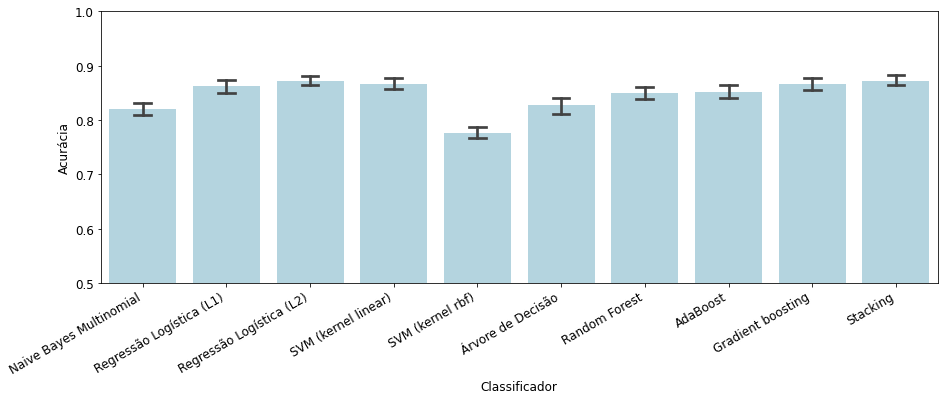

In [53]:
font = {'size': 12}

matplotlib.rc('font', **font)

plt.figure(figsize=(15,5))
plt.ylim(0.5, 1)
plt.xticks(rotation=30, ha='right')
sns.barplot(x='clf', y='accuracy', data=metrics_df, estimator=np.mean, ci=95, capsize=.2, color='lightblue')
plt.xlabel('Classificador')
plt.ylabel('Acurácia')